# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [28]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

In [29]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper

    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [45]:
def compute_average_enrichment(pkl_path, model):
    
    enrich_1_list = [] 
    enrich_10_list = []
    
#     import pdb
#     pdb.set_trace()
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
#         for seed in data.keys():

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):
#             print(seed)

            if isinstance(data[seed]["y_true"], np.ndarray):
                y_true = data[seed]["y_true"]
            else:
                y_true = np.concatenate(data[seed]["y_true"]) 
            y_pred = np.array(data[seed]["y_pred"])

    
            eta = np.array(data[seed]["eta"])

            if np.unique(y_true).shape[0] < 2 :
                metric = 0
            else:
                metric = recall_score(y_pred=y_pred, y_true=y_true)
                if model in ["rf", "mlp"]:
                    eta= eta[:, 1]

            enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
            enrich_1_list.append(enrich_1)
                
            enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
            enrich_10_list.append(enrich_10)
            
    
    return np.mean(enrich_1_list), np.std(enrich_1_list), np.mean(enrich_10_list), np.std(enrich_10_list)




def compute_average_train_time(pkl_path):
    print(pkl_path)
    train_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        target = pkl_path.name.split(".")[2]
        split = pkl_path.name.split(".")[1]
        model = pkl_path.name.split(".")[3]

        range_limit = 10
    
        if "openhd" in model:
            range_limit=1
        for seed in range(range_limit):

            train_time  = data[seed]["train_time"]

            if "openhd" in model:
                pass
            
            elif "mlp" in model:
                train_time = train_time / 10 # trained MLP for max 10 epochs...check that it hits that but assume it didn't converge that quickly
            elif "rf" in model:
                train_time = train_time # there's no concept of epoch in a random forest
            else:
                train_time = train_time/10 # this should catch all HD models which were trained for 10 epochs per seed
            
            train_time_list.append(train_time)
            
            
    
    return np.mean(train_time_list)



def compute_average_inference_time(pkl_path):
    
    test_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):

            test_time  = data[seed]["test_time"]

            test_time_list.append(test_time)
            
            
    
    return np.mean(test_time_list)
                    

In [46]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4")
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/0")
# data_p = Path("/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results")

In [47]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    print(pkl_path)
    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# LIT-PCBA Results

In [48]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [49]:
color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[2],
    "smiles-pe.bpe.0": rocket_color_pal[4],   
#     "smiles-pe.ngram.1": color_pal[0],
#     "selfies.None": "purple",
"selfies.atomwise": green_color_pal[4],
#     "selfies.selfies-charwise": color_pal[2],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
#     "openhd": "green",
    "mlp": blue_color_pal[7],
#     "Vina": color_pal[2]
}



marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
    "selfies.atomwise": "*",
#     "selfies.selfies-charwise": "*",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+",
#     "Vina": "+"
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
    ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
    ("ecfp", "HDBind-ECFP"),
    ("rp", "HDBind-ECFP+RP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
#     ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
    "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
    "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
    "ecfp": "HDBind-ECFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
}


linestyle_dict = {
    "smiles-pe.atomwise.0": "-", 
    "smiles-pe.bpe.0": ":",
    "selfies.None": "-",
    "ecfp": ":",
    "rp": "-.",
    "rf": "-",
    "mlp": ":",
    "Vina": "-"
}

In [65]:
def aggregate_results(dataset):
    
    
    
    
    model_metric_dict = {"model": [], "enrich-1-mean": [], 
                         "enrich-1-std":[], "enrich-10-mean": [], 
                         "enrich-10-std": [], "train_time":[], "test_time": []}
    

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    for model, color in color_dict.items():
                        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
        
        data_path_list = list(data_p.glob(f"{dataset}*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []

        
        for path in tqdm(data_path_list, total=len(data_path_list)):
            
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
                
                
            enrich_1_mean, enrich_1_std, enrich_10_mean, enrich_10_std = compute_average_enrichment(path, model=model)
            train_time_mean = compute_average_train_time(path)
            test_time_mean = compute_average_inference_time(path)
            
            
            model_metric_dict["model"].append(model)
            model_metric_dict["enrich-1-mean"].append(enrich_1_mean)
            model_metric_dict["enrich-1-std"].append(enrich_1_std)
            model_metric_dict["enrich-10-mean"].append(enrich_10_mean)
            model_metric_dict["enrich-10-std"].append(enrich_10_std)
            model_metric_dict["train_time"].append(train_time_mean)
            model_metric_dict["test_time"].append(test_time_mean)

    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




In [ ]:
lit_pcba_enrich_f, lit_pcba_enrich_1_ax, lit_pcba_enrich_10_ax, model_metric_dict = aggregate_results(dataset="lit_pcba")


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.smiles-pe.atomwise.0.pkl


  7%|▋         | 1/15 [00:15<03:35, 15.39s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.smiles-pe.atomwise.0.pkl


 13%|█▎        | 2/15 [00:35<03:59, 18.42s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.smiles-pe.atomwise.0.pkl


 27%|██▋       | 4/15 [00:45<01:40,  9.14s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.smiles-pe.atomwise.0.pkl


 33%|███▎      | 5/15 [00:46<00:59,  5.91s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.smiles-pe.atomwise.0.pkl


 40%|████      | 6/15 [00:46<00:35,  3.97s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.smiles-pe.atomwise.0.pkl


 60%|██████    | 9/15 [01:01<00:21,  3.61s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.smiles-pe.atomwise.0.pkl


 67%|██████▋   | 10/15 [01:22<00:45,  9.07s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.smiles-pe.atomwise.0.pkl


 80%|████████  | 12/15 [01:39<00:24,  8.18s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.smiles-pe.atomwise.0.pkl


 87%|████████▋ | 13/15 [01:58<00:22, 11.33s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.smiles-pe.atomwise.0.pkl


 93%|█████████▎| 14/15 [02:21<00:14, 14.80s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.smiles-pe.atomwise.0.pkl


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.smiles-pe.bpe.0.pkl


  7%|▋         | 1/15 [00:18<04:21, 18.69s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.smiles-pe.bpe.0.pkl


 13%|█▎        | 2/15 [00:36<03:58, 18.38s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.smiles-pe.bpe.0.pkl


 20%|██        | 3/15 [00:58<03:59, 19.98s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.smiles-pe.bpe.0.pkl


 33%|███▎      | 5/15 [01:20<02:12, 13.20s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.smiles-pe.bpe.0.pkl


 40%|████      | 6/15 [01:34<02:01, 13.54s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.smiles-pe.bpe.0.pkl


 53%|█████▎    | 8/15 [01:55<01:16, 10.89s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.smiles-pe.bpe.0.pkl


 60%|██████    | 9/15 [01:56<00:47,  7.94s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.smiles-pe.bpe.0.pkl


 73%|███████▎  | 11/15 [02:14<00:31,  7.86s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.smiles-pe.bpe.0.pkl


 80%|████████  | 12/15 [02:14<00:16,  5.53s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.smiles-pe.bpe.0.pkl


 93%|█████████▎| 14/15 [02:36<00:07,  7.33s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.smiles-pe.bpe.0.pkl


  7%|▋         | 1/15 [00:00<00:02,  4.71it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.selfies.atomwise.0.pkl


 13%|█▎        | 2/15 [00:18<02:22, 10.99s/it]

In [62]:
print([len(x) for x in model_metric_dict.values()])
print([x for x in model_metric_dict.keys()])

[0, 0, 0, 0, 0, 0, 0]
['model', 'enrich-1-mean', 'enrich-1-std', 'enrich-10-mean', 'enrich-10-std', 'train_time', 'test_time']


In [57]:
model_metric_dict

{'model': ['smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',


In [55]:
# 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'rf', 'mlp'

In [56]:
# import pdb 
# pdb.set_trace()

model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

ValueError: All arrays must be of the same length

In [39]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

In [40]:
# sns.boxplot(data=model_metric_df, x="model", y="metric", ax=lit_pcba_ax[0], palette=color_dict)
# lit_pcba_f

In [41]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=lit_pcba_enrich_1_ax, palette=color_dict)
lit_pcba_enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
lit_pcba_enrich_1_ax.set_xlabel("")
lit_pcba_enrich_1_ax.set_ylabel("")
lit_pcba_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

# lit_pcba_enrich_1_ax.set_xticklabels(labels)
# labels = [x[1] for x in model_order_list]
# labels = [model_name_dict[x.get_text()] for x in lit_pcba_enrich_1_ax.get_xticklabels()]
# lit_pcba_enrich_1_ax.set_xticklabels(labels)
plt.tight_layout()




plt.tight_layout()
# lit_pcba_enrich_1_f.savefig("lit_pcba_enrich_1.png", dpi=600, bbox_inches="tight")
# lit_pcba_enrich_1_f

<Figure size 432x288 with 0 Axes>

In [42]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=lit_pcba_enrich_10_ax, palette=color_dict)
lit_pcba_enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
lit_pcba_enrich_10_ax.set_xlabel("")
lit_pcba_enrich_10_ax.set_ylabel("")
lit_pcba_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
labels = [item.get_text() for item in lit_pcba_enrich_10_ax.get_xticklabels()]
labels = [model_name_dict[x.get_text()] for x in lit_pcba_enrich_10_ax.get_xticklabels()]
lit_pcba_enrich_10_ax.set_xticklabels(labels)
plt.tight_layout()
# lit_pcba_enrich_10_f.savefig("lit_pcba_enrich_10.png", dpi=600, bbox_inches="tight")
# lit_pcba_enrich_10_f

<Figure size 432x288 with 0 Axes>

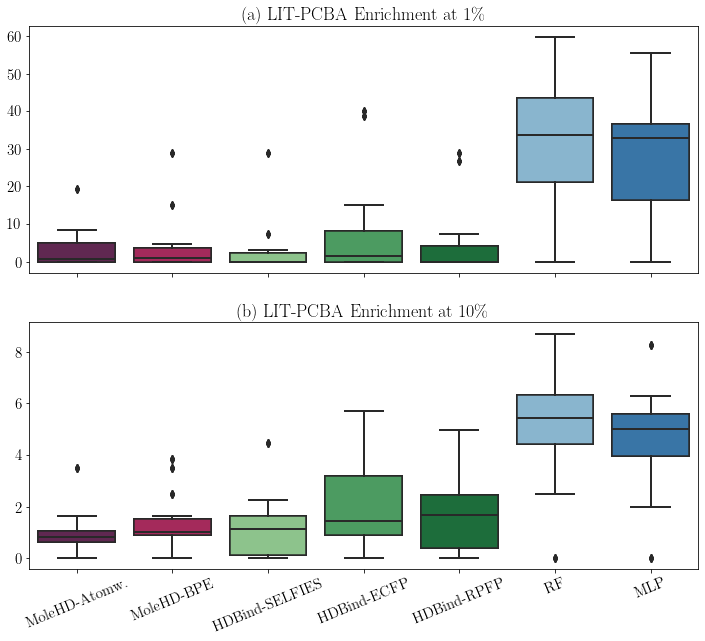

In [43]:
lit_pcba_enrich_f.savefig("lit_pcba_enrich.png", dpi=600, bbox_inches="tight")

lit_pcba_enrich_f


In [44]:
model_metric_df[['enrich-1', 'enrich-10', 'model']].groupby("model").describe()

enrich-1                                        \
                        count       mean        std  min        25%   
model                                                                 
ecfp                     15.0   8.019573  13.435771  0.0   0.000000   
mlp                      15.0  28.271508  15.514943  0.0  16.349797   
rf                       15.0  32.085894  17.058962  0.0  21.214078   
rp                       15.0   5.141009   9.503962  0.0   0.000000   
selfies.atomwise         15.0   3.138158   7.430973  0.0   0.000000   
smiles-pe.atomwise.0     15.0   3.269984   5.435694  0.0   0.000000   
smiles-pe.bpe.0          15.0   4.072679   7.897178  0.0   0.000000   

                                                      enrich-10            \
                            50%        75%        max     count      mean   
model                                                                       
ecfp                   1.457911   8.056428  40.102041      15.0  2.075731   
mlp                   33.019811  36.530980  55.399279      15.0  4.645546   
rf                    33.630178  43.635317  59.744321      15.0  5.160545   
rp                     0.000000   4.110769  28.963636      15.0  1.708714   
selfies.atomwise       0.000000   2.379619  28.963636      15.0  1.163737   
smiles-pe.atomwise.0   0.728955   4.926440  19.309091      15.0  0.931914   
smiles-pe.bpe.0        1.086260   3.581334  28.963636      15.0  1.388890   

                                                                             
                           std  min       25%       50%       75%       max  
model                                                                        
ecfp                  1.780635  0.0  0.891003  1.428475  3.165344  5.714286  
mlp                   1.972508  0.0  3.970361  4.999680  5.595053  8.260219  
rf                    2.051513  0.0  4.419168  5.415357  6.316158  8.694968  
rp                    1.526242  0.0  0.413714  1.666264  2.460657  4.962617  
selfies.atomwise      1.194694  0.0  0.119040  1.147486  1.635097  4.466355  
smiles-pe.atomwise.0  0.851518  0.0  0.616776  0.833132  1.065554  3.473832  
smiles-pe.bpe.0       1.095711  0.0  0.892724  1.020361  1.528883  3.824955